In [2]:
from argparse import Namespace
from collections import Counter
import json
import os
import string

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

In [17]:
class Vocabulary(object):
    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>") -> None:
        if token_to_idx is None:
            token_to_idx = dict()
        self._token_to_idx = token_to_idx
        self._idx_to_token = {
            idx: token
            for token, idx in self._token_to_idx.items()
        }
        self._add_unk = add_unk
        self._unk_token = unk_token
        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token)

    def to_serializable(self):
        return {
            'token_to_idx': self._token_to_idx,
            'add_unk': self._add_unk,
            'unk_token': self._unk_token
        }

    @classmethod
    def from_serializable(cls, contents):
        return cls(**contents)

    def add_token(self, token):
        try:
            index = self._token_to_idx[token]
        except KeyError:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index

    def add_many(self, tokens):
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):
        if index not in self._idx_to_token:
            raise KeyError
        return self._idx_to_token[index]

    def __str__(self):
        return f"<Vocabulary size={len(self)}>" 

    def __len__(self):
        return len(self._token_to_idx)

class SurnameVectorizer(object):
    def __init__(self, surname_vocab, nationality_vocab) -> None:
        self.surname_vocab = surname_vocab
        self.nationality_vocab = nationality_vocab

    def vectorize(self, surname):
        vocab = self.surname_vocab
        one_hot = np.zeros(len(vocab), dtype=np.float32)
        for token in surname:
            one_hot[vocab.lookup_token(token)] = 1
        return one_hot

    @classmethod
    def from_dataframe(cls, surname_df):
        surname_vocab = Vocabulary(unk_token="@")
        nationality_vocab = Vocabulary(add_unk=False)
        for index, row in surname_df.iterrows():
            for letter in row.surname:
                surname_vocab.add_token(letter)
            nationality_vocab.add_token(row.nationality)
        return cls(surname_vocab, nationality_vocab)

    @classmethod
    def from_serializable(cls, contents):
        surname_vocab = Vocabulary.from_serializable(contents['surname_vocab'])
        nationality_vocab = Vocabulary.from_serializable(contents['nationality_vocab'])
        return cls(surname_vocab, nationality_vocab)

    def to_serializable(self):
        return {
            'surname_vocab': self.surname_vocab.to_serializable(),
            'nationality_vocab': self.nationality_vocab.to_serializable()
        }

class SurnameDataset(Dataset):
    def __init__(self, surname_df, vectorizer):
        self.surname_df = surname_df
        self._vectorizer = vectorizer

        self.train_df = self.surname_df[self.surname_df.split == 'train']
        self.train_size = len(self.train_df)

        self.val_df = self.surname_df[self.surname_df.split == 'val']
        self.val_size = len(self.val_df)

        self.test_df = self.surname_df[self.surname_df.split == 'test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {
            'train': (self.train_df, self.train_size),
            'val': (self.val_df, self.val_size),
            'test': (self.test_df, self.test_size)
        }
        self.set_split('train')

        #class weights
        class_counts = surname_df.nationality.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.nationality_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequences = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequences, dtype=torch.float32)

    @classmethod
    def load_dataset_and_make_vectorizer(cls, surname_csv):
        surname_df = pd.read_csv(surname_csv)
        train_surname_df = surname_df[surname_df.split=='train']
        return cls(surname_df, SurnameVectorizer.from_dataframe(train_surname_df))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, surname_csv, vectorizer_filepath):
        surname_df = pd.read_csv(surname_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(surname_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        with open(vectorizer_filepath) as fp:
            return SurnameVectorizer.from_serializable(json.load(fp))
    
    def save_vectorizer(self, vectorizer_filepath):
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        return self._vectorizer
    
    def set_split(self, split='train'):
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        row = self._target_df.iloc[index]
        surname_vector = self._vectorizer.vectorize(row.surname)
        nationality_index = self._vectorizer.nationality_vocab.lookup_token(row.nationality)
        return {
            'x_surname': surname_vector,
            'y_nationality': nationality_index
        }
    def get_num_batches(self, batch_size):
        return len(self) // batch_size
    
def generate_batches(dataset, batch_size, shuffle=True, drop_last=True, device="cpu"):
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)
    for data_dict in dataloader:
        out_data_dict = dict()
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

In [18]:
class SurnameClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SurnameClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x_in, apply_softmax=False):
        intermediate_vector = torch.relu(self.fc1(x_in))
        prediction_vector = self.fc2(intermediate_vector)
        if apply_softmax:
            prediction_vector = torch.softmax(prediction_vector, dim=1)
        return prediction_vector

In [38]:
def make_train_stage(args):
    return {
        'stop_early': False,
        'early_stopping_step': 0,
        'early_stopping_best_val': 1e8,
        'learning_rate': args.learning_rate,
        'epoch_index': 0,
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'test_loss': -1,
        'test_acc': -1,
        'model_filename': args.model_state_file
    }
def update_train_state(args, model, train_state):
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]
        if loss_t >= train_state['early_stopping_best_val']:
            train_state['early_stopping_step'] += 1
        else:
            if loss_t >= train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
            train_state['early_stopping_step'] = 0
        train_state['stop_early'] = train_state['early_stopping_step'] >= args.early_stopping_criteria
        
    return train_state
def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [39]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

In [40]:
args = Namespace(
    # Data and path information
    surname_csv="../data/surnames/surname_with_splits.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="../model_storage/ch4/surname_mlp",
    # Model hyper parameters
    hidden_dim=300,
    # Training  hyper parameters
    seed=1337,
    num_epochs=100,
    early_stopping_criteria=5,
    learning_rate=0.001,
    batch_size=64,
    # Runtime options
    cuda=False,
    reload_from_files=False,
    expand_filepaths_to_save_dir=True,
)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(
        args.save_dir,
        args.vectorizer_file
    )
    args.model_state_file = os.path.join(
        args.save_dir,
        args.model_state_file
    )
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("Using CUDA: {}".format(args.cuda))

set_seed_everywhere(args.seed, args.cuda)

handle_dirs(args.save_dir)

Expanded filepaths: 
	../model_storage/ch4/surname_mlp\vectorizer.json
	../model_storage/ch4/surname_mlp\model.pth
Using CUDA: False


In [41]:
if args.reload_from_files:
    # training from a checkpoint
    print("Reloading!")
    dataset = SurnameDataset.load_dataset_and_load_vectorizer(args.surname_csv,
                                                              args.vectorizer_file)
else:
    # create dataset and vectorizer
    print("Creating fresh!")
    dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
    dataset.save_vectorizer(args.vectorizer_file)
    
vectorizer = dataset.get_vectorizer()
classifier = SurnameClassifier(input_dim=len(vectorizer.surname_vocab), 
                               hidden_dim=args.hidden_dim, 
                               output_dim=len(vectorizer.nationality_vocab))

Creating fresh!


In [42]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)

loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = opt.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = opt.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer,
    mode='min',
    factor=0.5,
    patience=1
)
train_state = make_train_stage(args)

epoch_bar = tqdm(desc='training routine', total=args.num_epochs, position=0)

dataset.set_split('train')
train_bar = tqdm(desc='split=train', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)

dataset.set_split('val')
val_bar = tqdm(desc='split=val', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index
        dataset.set_split("train")
        batch_generator = generate_batches(dataset, batch_size=args.batch_size, device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()
        for batch_index, batch_dict in enumerate(batch_generator):
            
            classifier.zero_grad()
            
            y_pred = classifier(x_in=batch_dict['x_surname'])
            
            loss = loss_func(y_pred, batch_dict['y_nationality'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)
            
            loss.backward()
            
            optimizer.step()
            
            acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            train_bar.set_postfix(loss = running_loss, acc=running_acc, epoch=epoch_index)
            train_bar.update()
        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)
        
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, batch_size=args.batch_size, device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.eval()
        for batch_index, batch_dict in enumerate(batch_generator):
            y_pred = classifier(x_in=batch_dict['x_surname'])
            loss_t = loss_func(y_pred, batch_dict['y_nationality']).to("cpu").item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)
            
            acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
            val_bar.update()
        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)
        
        train_state = update_train_state(args=args, model=classifier, train_state=train_state)
        scheduler.step(train_state['val_loss'][-1])
        
        if train_state['stop_early']:
            break
        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
except KeyboardInterrupt:
    print("Exiting")

training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/120 [00:00<?, ?it/s]

split=val:   0%|          | 0/25 [00:00<?, ?it/s]

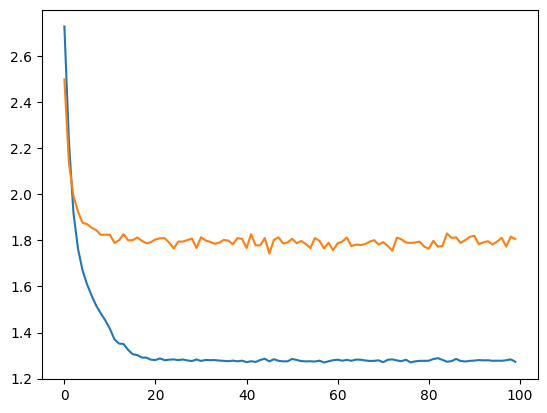

In [45]:
import matplotlib.pyplot as plt
plt.plot(train_state['train_loss'])
plt.plot(train_state['val_loss'])

In [43]:
# test
classifier.load_state_dict(torch.load(train_state['model_filename']))

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('test')
batch_generator = generate_batches(dataset, batch_size=args.batch_size, device=args.device)
running_loss = 0.0
running_acc = 0.0
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    y_pred = classifier(batch_dict['x_surname'])
    loss_t = loss_func(y_pred, batch_dict['y_nationality']).item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)
    
    acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)
    
train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc
print(f"Test Loss = {train_state['test_loss']}")
print(f"Test acc = {train_state['test_acc']}")

Test Loss = 2.499373741149902
Test acc = 39.56250000000001


In [49]:
def predict_nationality(surname, classifier, vectorizer):
    vectorized_name = vectorizer.vectorize(surname)
    vectorized_name = torch.tensor(vectorized_name).view(1, -1)
    result = classifier(vectorized_name, apply_softmax=True)
    
    probability_values, indices = result.max(dim=1)
    index = indices.item()
    
    predicted_nationality = vectorizer.nationality_vocab.lookup_index(index)
    probability_value = probability_values.item()
    
    return {'nationality': predicted_nationality, 'probability': probability_value}

In [54]:
surname = "Khodosevich"
prediction = predict_nationality(surname, classifier, vectorizer)
print(f"Surname {surname} is {prediction['nationality']} with probability {prediction['probability']}")

Surname Khodosevich is Russian with probability 0.35886234045028687


In [55]:
def predict_topk_nationality(name, classifier, vectorizer, k=5):
    vectorized_name = vectorizer.vectorize(name)
    vectorized_name = torch.tensor(vectorized_name).view(1, -1)
    prediction_vector = classifier(vectorized_name, apply_softmax=True)
    probability_values, indices = torch.topk(prediction_vector, k=k)
    
    # returned size is 1,k
    probability_values = probability_values.detach().numpy()[0]
    indices = indices.detach().numpy()[0]
    
    results = []
    for prob_value, index in zip(probability_values, indices):
        nationality = vectorizer.nationality_vocab.lookup_index(index)
        results.append({'nationality': nationality, 
                        'probability': prob_value})
    
    return results

surname = "Khodosevich"
prediction = predict_topk_nationality(surname, classifier, vectorizer)
print(f"Surname {surname} is:")
for pred in prediction:
    print(f"{pred['nationality']}(p={pred['probability']})")

Surname Khodosevich is:
Russian(p=0.35886234045028687)
Czech(p=0.08388100564479828)
Greek(p=0.06598647683858871)
Polish(p=0.056847747415304184)
Italian(p=0.04762723296880722)


# Now try with dropout

In [69]:
class SurnameClassifierDropout(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SurnameClassifierDropout, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x_in, apply_softmax=False):
        intermediate_vector = torch.relu(self.fc1(x_in))
        prediction_vector = self.fc2(F.dropout(intermediate_vector, p=0.2))
        if apply_softmax:
            prediction_vector = torch.softmax(prediction_vector, dim=1)
        return prediction_vector

In [70]:
args = Namespace(
    # Data and path information
    surname_csv="../data/surnames/surname_with_splits.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="../model_storage/ch4/surname_mlp",
    # Model hyper parameters
    hidden_dim=300,
    # Training  hyper parameters
    seed=1337,
    num_epochs=100,
    early_stopping_criteria=5,
    learning_rate=0.001,
    batch_size=64,
    # Runtime options
    cuda=False,
    reload_from_files=False,
    expand_filepaths_to_save_dir=True,
)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(
        args.save_dir,
        args.vectorizer_file
    )
    args.model_state_file = os.path.join(
        args.save_dir,
        args.model_state_file
    )
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("Using CUDA: {}".format(args.cuda))

set_seed_everywhere(args.seed, args.cuda)

handle_dirs(args.save_dir)

Expanded filepaths: 
	../model_storage/ch4/surname_mlp\vectorizer.json
	../model_storage/ch4/surname_mlp\model.pth
Using CUDA: False


In [71]:
if args.reload_from_files:
    # training from a checkpoint
    print("Reloading!")
    dataset = SurnameDataset.load_dataset_and_load_vectorizer(args.surname_csv,
                                                              args.vectorizer_file)
else:
    # create dataset and vectorizer
    print("Creating fresh!")
    dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
    dataset.save_vectorizer(args.vectorizer_file)
    
vectorizer = dataset.get_vectorizer()
classifier = SurnameClassifierDropout(input_dim=len(vectorizer.surname_vocab), 
                               hidden_dim=args.hidden_dim, 
                               output_dim=len(vectorizer.nationality_vocab))

Creating fresh!


In [72]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)

loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = opt.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = opt.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer,
    mode='min',
    factor=0.5,
    patience=1
)
train_state = make_train_stage(args)

epoch_bar = tqdm(desc='training routine', total=args.num_epochs, position=0)

dataset.set_split('train')
train_bar = tqdm(desc='split=train', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)

dataset.set_split('val')
val_bar = tqdm(desc='split=val', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index
        dataset.set_split("train")
        batch_generator = generate_batches(dataset, batch_size=args.batch_size, device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()
        for batch_index, batch_dict in enumerate(batch_generator):
            
            classifier.zero_grad()
            
            y_pred = classifier(x_in=batch_dict['x_surname'])
            
            loss = loss_func(y_pred, batch_dict['y_nationality'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)
            
            loss.backward()
            
            optimizer.step()
            
            acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            train_bar.set_postfix(loss = running_loss, acc=running_acc, epoch=epoch_index)
            train_bar.update()
        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)
        
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, batch_size=args.batch_size, device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.eval()
        for batch_index, batch_dict in enumerate(batch_generator):
            y_pred = classifier(x_in=batch_dict['x_surname'])
            loss_t = loss_func(y_pred, batch_dict['y_nationality']).to("cpu").item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)
            
            acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
            val_bar.update()
        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)
        
        train_state = update_train_state(args=args, model=classifier, train_state=train_state)
        scheduler.step(train_state['val_loss'][-1])
        
        if train_state['stop_early']:
            break
        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
except KeyboardInterrupt:
    print("Exiting")

training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/120 [00:00<?, ?it/s]

split=val:   0%|          | 0/25 [00:00<?, ?it/s]

In [73]:
# test
classifier.load_state_dict(torch.load(train_state['model_filename']))

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('test')
batch_generator = generate_batches(dataset, batch_size=args.batch_size, device=args.device)
running_loss = 0.0
running_acc = 0.0
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    y_pred = classifier(batch_dict['x_surname'])
    loss_t = loss_func(y_pred, batch_dict['y_nationality']).item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)
    
    acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)
    
train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc
print(f"Test Loss = {train_state['test_loss']}")
print(f"Test acc = {train_state['test_acc']}")

Test Loss = 2.5474995136260987
Test acc = 39.81250000000001


In [74]:
surname = "Ivanov"
prediction = predict_topk_nationality(surname, classifier, vectorizer)
print(f"Surname {surname} is:")
for pred in prediction:
    print(f"{pred['nationality']}(p={pred['probability']})")

Surname Ivanov is:
Russian(p=0.17151635885238647)
Japanese(p=0.07518443465232849)
Chinese(p=0.061876729130744934)
Italian(p=0.06119128316640854)
English(p=0.05978820472955704)


In [77]:
vectorizer.vectorize("Ivanof")

array([0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)